## Installing dependencies

In [211]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install -U scikit-learn
!pip install seaborn

## Import dataset 
#### Save the dataset in the same path

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv('merge_data_2018_2022.csv')

## Change to hourly frquency

In [2]:
df = df.set_index('DATETIME')
df.index = pd.to_datetime(df.index)
df=df.loc[~df.index.duplicated(), :]
df=df.asfreq('H')
df.index

DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00',
               '2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               ...
               '2022-08-28 15:00:00', '2022-08-28 16:00:00',
               '2022-08-28 17:00:00', '2022-08-28 18:00:00',
               '2022-08-28 19:00:00', '2022-08-28 20:00:00',
               '2022-08-28 21:00:00', '2022-08-28 22:00:00',
               '2022-08-28 23:00:00', '2022-08-29 00:00:00'],
              dtype='datetime64[ns]', name='DATETIME', length=40824, freq='H')

## Import dataset with gas price

In [3]:
df2 = pd.read_csv('DataforTagbo.csv')
df2 = df2.set_index('DATETIME')
df2.index = pd.to_datetime(df.index)
df2=df2.loc[~df.index.duplicated(), :]
df2=df2.asfreq('H')
df2.index


DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00',
               '2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               ...
               '2022-08-28 15:00:00', '2022-08-28 16:00:00',
               '2022-08-28 17:00:00', '2022-08-28 18:00:00',
               '2022-08-28 19:00:00', '2022-08-28 20:00:00',
               '2022-08-28 21:00:00', '2022-08-28 22:00:00',
               '2022-08-28 23:00:00', '2022-08-29 00:00:00'],
              dtype='datetime64[ns]', name='DATETIME', length=40824, freq='H')

In [4]:
df['Gas_Price'] = df2.Gas_Price

## Subset only relevant features

In [5]:
df.columns

Index(['Unnamed: 0', 'index', 'CFLATS_UNIT..RTLMP.', 'HB_NORTH..RTLMP.',
       'WAKEWE_ALL..RTLMP.', 'CFLATS_UNIT..DALMP.', 'HB_NORTH..DALMP.',
       'WAKEWE_ALL..DALMP.', 'ERCOT..LOAD_FORECAST.', 'ERCOT..RTLOAD.',
       'ERCOT..WIND_STWPF.', 'ERCOT..WINDDATA.', 'GR_PANHANDLE..WIND_STWPF.',
       'GR_PANHANDLE..WINDDATA.', 'GR_WEST..WIND_STWPF.',
       'ERCOT..WIND_STWPF..1', 'GR_WEST..WINDDATA.',
       'Panhandle..ERCOT_DA_GENERIC_CONSTRAINTS.', 'WAKEWE_ALL..DARTLMP.',
       'TYLRWIND_RN..DARTLMP.',
       'West.Texas.Export..ERCOT_DA_GENERIC_CONSTRAINTS.',
       'ERCOT..SOLAR_PVGRPP.', 'HOURENDING', 'MARKETDAY', 'PEAKTYPE', 'MONTH',
       'YEAR', 'Gas_Price'],
      dtype='object')

In [6]:
df = df[['WAKEWE_ALL..RTLMP.','ERCOT..WINDDATA.', 'ERCOT..LOAD_FORECAST.', 'ERCOT..WIND_STWPF.',
             
            'ERCOT..SOLAR_PVGRPP.', 'PEAKTYPE']]

## Feature engineering to add more features

In [7]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
#df['year'] = df.index.year
#df['dayofyear'] = df.index.dayofyear
#df['dayofmonth'] = df.index.day
#df['weekofyear'] = df.index.isocalendar().week

In [8]:
df.isna().sum()

WAKEWE_ALL..RTLMP.       5
ERCOT..WINDDATA.         5
ERCOT..LOAD_FORECAST.    5
ERCOT..WIND_STWPF.       5
ERCOT..SOLAR_PVGRPP.     7
PEAKTYPE                 5
hour                     0
dayofweek                0
quarter                  0
month                    0
dtype: int64

## Imputing extreme values using KNN

In [218]:
df['Is_KNN_Outlier'] = df['WAKEWE_ALL..RTLMP.'].map(lambda x: np.nan if x >= 300 or x <= -20 else x)

In [219]:
df['Is_KNN_Outlier'].isna().sum()

2544

In [220]:
from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors=5, add_indicator=True)
knn.fit(df[['Is_KNN_Outlier']])
cc = pd.DataFrame(knn.transform(df[['Is_KNN_Outlier']]), columns = ['A', 'B'])
cc[['A']].isna().sum()

A    0
dtype: int64

In [222]:
cc = cc.set_index(df.index)
df['KNN_Transformed'] = cc['A']
len(df['KNN_Transformed'])

40824

In [225]:
df = df.dropna()

## Creating dummy variables

In [9]:
categorical_col = ['hour','dayofweek','month','quarter','PEAKTYPE']
df = pd.get_dummies(df, columns = categorical_col)
df.head()

,WAKEWE_ALL..RTLMP.,ERCOT..WINDDATA.,ERCOT..LOAD_FORECAST.,ERCOT..WIND_STWPF.,ERCOT..SOLAR_PVGRPP.,hour_0,hour_1,hour_2,hour_3,hour_4,...,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,PEAKTYPE_OFFPEAK,PEAKTYPE_WDPEAK,PEAKTYPE_WEPEAK
DATETIME,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,27.6375,4638.259167,49367.877441,4885.2,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2018-01-01 02:00:00,27.7000,4536.514167,48668.364014,4804.2,0.0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2018-01-01 03:00:00,27.4400,4541.879167,48351.732544,4569.9,0.0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2018-01-01 04:00:00,27.9575,4574.777500,48621.932007,4472.7,0.0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2018-01-01 05:00:00,28.8075,4481.792500,49914.561890,4386.4,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [10]:
df.columns

Index(['WAKEWE_ALL..RTLMP.', 'ERCOT..WINDDATA.', 'ERCOT..LOAD_FORECAST.',
       'ERCOT..WIND_STWPF.', 'ERCOT..SOLAR_PVGRPP.', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'dayofweek_0', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4',
       'PEAKTYPE_OFFPEAK', 'PEAKTYPE_WDPEAK', 'PEAKTYPE_WEPEAK'],
      dtype='object')

## Train_test split for time series

In [227]:
filt1 = (df.index<pd.to_datetime('2022-08-22'))
train = df.loc[filt1]

filt2 = (df.index>=pd.to_datetime('2022-08-22'))
test = df.loc[filt2]


In [228]:
train_y = train[['KNN_Transformed']]

In [230]:
train_X = train.reset_index().drop(['DATETIME', 'WAKEWE_ALL..RTLMP.','KNN_Transformed','Is_KNN_Outlier'
                                    ], axis=1)

In [232]:
test_X = test.reset_index().drop(['DATETIME', 'WAKEWE_ALL..RTLMP.','KNN_Transformed','Is_KNN_Outlier'
                                    ], axis=1)

## Grid search for optimum model parameter values

In [ ]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 3, 4],
               'min_samples_split': [1,2, 3,4,5, 10],
               "n_estimators": np.arange(10, 200, 10)}
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(scoring="neg_mean_squared_error", estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(train_X, train_y)
df2 = pd.DataFrame(rf_random.cv_results_)

In [159]:
rf_random.best_params_

{'n_estimators': 20,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

## Model training (Random Forest)

C:\Users\TAGBOA~1\AppData\Local\Temp/ipykernel_37180/1033994191.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(train_X, train_y)


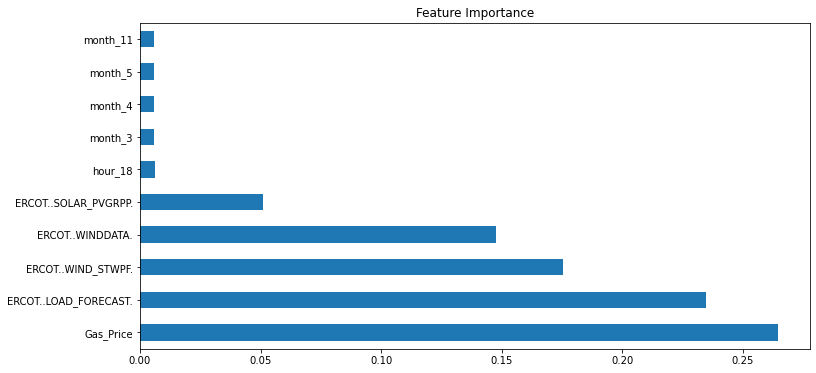

In [290]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(**rf_random.best_params_, random_state=42)
forest_reg.fit(train_X, train_y)
feat_importances = pd.Series(forest_reg.feature_importances_, index=train_X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(12,6))
plt.title('Feature Importance')
plt.show()

## Model prediction for week ahead

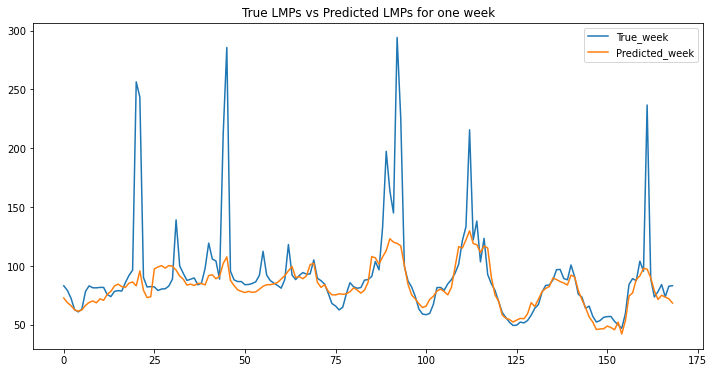

SMAPE for Random Forest for week ahead :  12.48%


In [270]:
import numpy as np
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
pred1 = forest_reg.predict(test_X)
tt = test['KNN_Transformed'].reset_index()
tt['True_week'] = tt['KNN_Transformed']
tt['Predicted_week'] = pred1
tt[['True_week', 'Predicted_week']].plot(legend=True,figsize=(12,6))
plt.title('True LMPs vs Predicted LMPs for one week')
plt.show()
err1 = smape(tt['KNN_Transformed'], pred1)
print('SMAPE for Random Forest for week ahead : ', "{:.4}%".format(err1))

## Point prediction values

In [287]:
tt[['DATETIME','True_week', 'Predicted_week']].head(6)

,DATETIME,True_week,Predicted_week
0,2022-08-22 00:00:00,83.2050,72.838627
1,2022-08-22 01:00:00,79.3225,68.926666
2,2022-08-22 02:00:00,72.6325,66.345676
3,2022-08-22 03:00:00,62.8700,62.802767
4,2022-08-22 04:00:00,61.0475,61.582966
5,2022-08-22 05:00:00,63.3525,62.690386


## Model prediction for day ahead

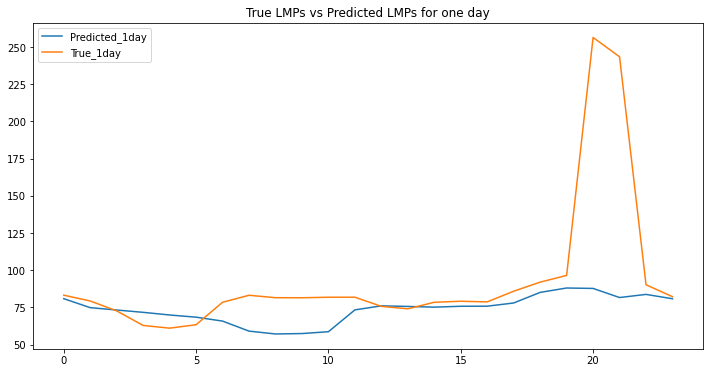

SMAPE for Random Forest model for day ahead:  19.06%


In [289]:
pred2 = forest_reg.predict(test_X.iloc[:24,])
aa = pd.DataFrame(pred2, columns = ['Predicted_1day'])
bb = pd.DataFrame(tt['KNN_Transformed'].iloc[:24,])
aa['True_1day'] = bb['KNN_Transformed']
aa.plot(legend=True,figsize=(12,6))
plt.title('True LMPs vs Predicted LMPs for one day')
plt.show()
err1 = smape(tt['KNN_Transformed'].iloc[:24,], pred2)
print('SMAPE for Random Forest model for day ahead: ', "{:.4}%".format(err1))

## Model training (XGBoost with Huber loss)

C:\Users\Tagbo Aroh\Miniconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


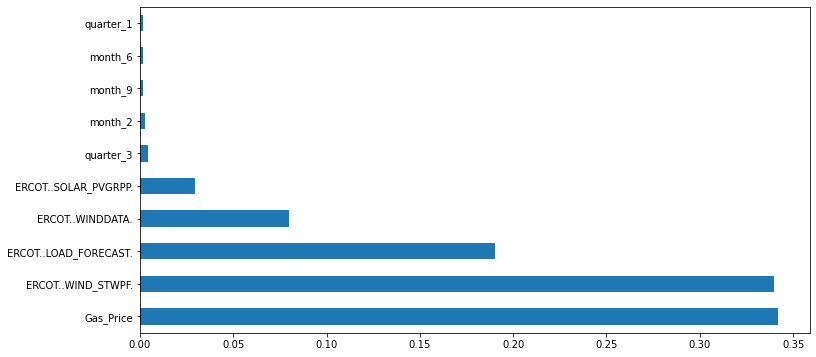

In [173]:
from sklearn.ensemble import GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "huber",
}
XGB_reg = GradientBoostingRegressor(**params)
XGB_reg.fit(train_X, train_y)
feat_importances = pd.Series(XGB_reg.feature_importances_, index=train_X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(12,6))
plt.show()

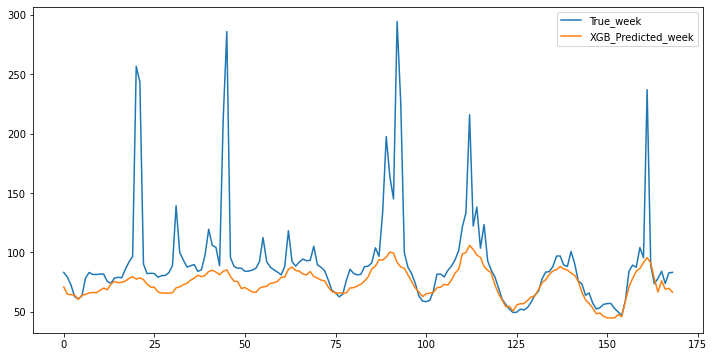

SMAPE for XGB for week ahead :  17.74%


In [174]:
pred2 = XGB_reg.predict(test_X)
tt['XGB_Predicted_week'] = pred2
tt[['True_week', 'XGB_Predicted_week']].plot(legend=True,figsize=(12,6))
plt.show()
err1 = smape(tt['KNN_Transformed'], pred2)
print('SMAPE for XGB for week ahead : ', "{:.4}%".format(err1))

## Model training (MLP)

C:\Users\Tagbo Aroh\Miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


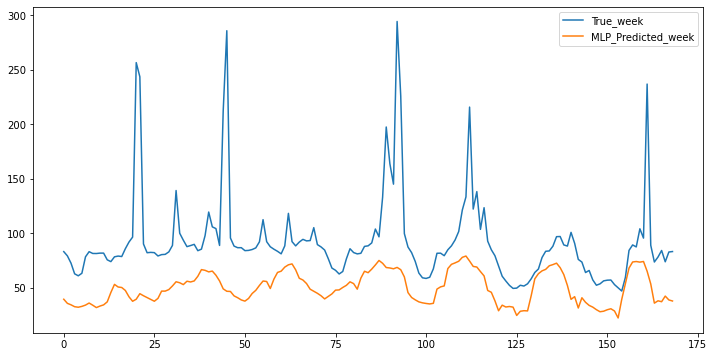

SMAPE for MLP for week ahead :  56.11%


In [179]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(50,50,50), max_iter=2000)
mlp.fit(train_X, train_y)
y_pred_mlp = mlp.predict(test_X)
tt['MLP_Predicted_week'] = y_pred_mlp
tt[['True_week', 'MLP_Predicted_week']].plot(legend=True,figsize=(12,6))
plt.show()
err1 = smape(tt['KNN_Transformed'], y_pred_mlp)
print('SMAPE for MLP for week ahead : ', "{:.4}%".format(err1))

## Median Smoothing Option

In [273]:
df2 = df.copy()
rolling = df2['WAKEWE_ALL..RTLMP.'].rolling(window=7)
df2['Median Smooth'] = rolling.median()

In [274]:
df2 = df2.dropna()
filt1 = (df2.index<pd.to_datetime('2022-08-22'))
train = df2.loc[filt1]

filt2 = (df2.index>=pd.to_datetime('2022-08-22'))
test = df2.loc[filt2]
train_y1 = train[['Median Smooth']]
train_X1 = train.reset_index().drop(['DATETIME','Median Smooth', 'WAKEWE_ALL..RTLMP.', 'KNN_Transformed','Is_KNN_Outlier'
                                    ], axis=1)
test_X1 = test.reset_index().drop(['DATETIME','Median Smooth', 'WAKEWE_ALL..RTLMP.','KNN_Transformed','Is_KNN_Outlier' 
                                    ], axis=1)


C:\Users\TAGBOA~1\AppData\Local\Temp/ipykernel_37180/98123801.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(train_X1, train_y1)


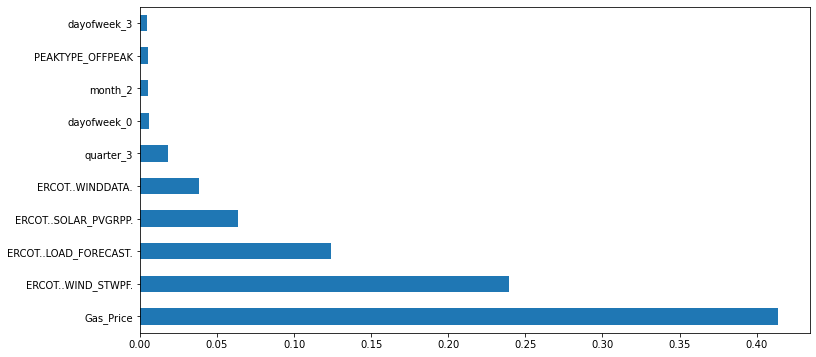

In [275]:

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(**rf_random.best_params_, random_state=42)
forest_reg.fit(train_X1, train_y1)
feat_importances = pd.Series(forest_reg.feature_importances_, index=train_X1.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(12,6))
plt.show()

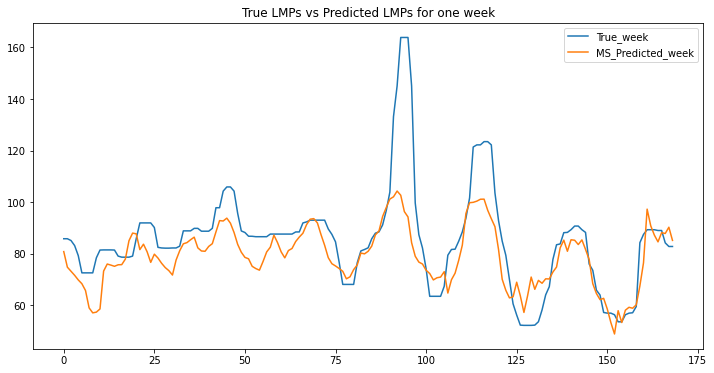

SMAPE for MS_RF for week ahead :  10.52%


In [276]:
pred4 = forest_reg.predict(test_X)
tt1 = test['Median Smooth'].reset_index()
tt1['True_week'] = tt1['Median Smooth']
tt1['MS_Predicted_week'] = pred4
tt1[['True_week', 'MS_Predicted_week']].plot(legend=True,figsize=(12,6))
plt.title('True LMPs vs Predicted LMPs for one week')
plt.show()
err1 = smape(tt1['Median Smooth'], pred4)
print('SMAPE for MS_RF for week ahead : ', "{:.4}%".format(err1))

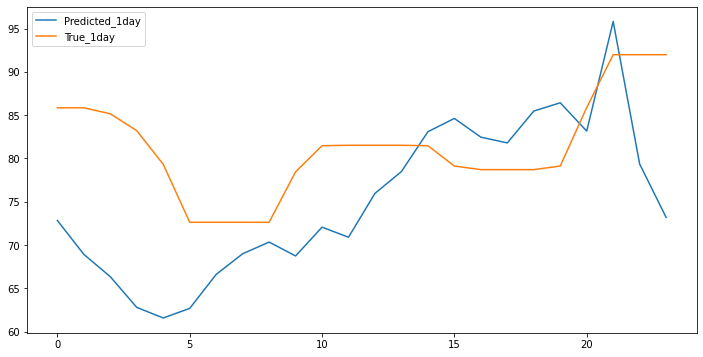

SMAPE for MS_RF for day ahead:  11.55%


In [293]:
pred2 = forest_reg.predict(test_X.iloc[:24,])
aa = pd.DataFrame(pred2, columns = ['Predicted_1day'])
bb = pd.DataFrame(tt1['Median Smooth'].iloc[:24,])
aa['True_1day'] = bb['Median Smooth']
aa.plot(legend=True,figsize=(12,6))
plt.show()

err1 = smape(tt1['Median Smooth'].iloc[:24,], pred2)
print('SMAPE for MS_RF for day ahead: ', "{:.4}%".format(err1))